In [ ]:
!pip install pulp

In [ ]:
import random
from pulp import LpProblem, LpVariable, lpSum, LpBinary, LpMinimize, PULP_CBC_CMD


In [ ]:
# Define the number of flights and pairings
num_flights = 50  # Total number of flights
num_pairings = 20  # Total number of pairings

# Generate random flights
flights = list(range(1, num_flights + 1))

# Generate random pairings with better coverage
pairings = {'P1': {'flights': [12, 38, 33, 28, 5, 30], 'cost': 457},
            'P2': {'flights': [48, 34, 14], 'cost': 207},
            'P3': {'flights': [44, 13, 29, 1, 10], 'cost': 122},
            'P4': {'flights': [44, 50, 48, 21, 28, 38, 41, 23], 'cost': 192},
            'P5': {'flights': [5, 38, 49, 27, 37, 39, 45, 26], 'cost': 470},
            'P6': {'flights': [45, 4, 31, 23, 21, 15], 'cost': 225},
            'P7': {'flights': [14, 38, 39, 8, 18, 3, 16], 'cost': 281},
            'P8': {'flights': [44, 17, 21, 47, 38, 48], 'cost': 237},
            'P9': {'flights': [24, 9, 10], 'cost': 290},
            'P10': {'flights': [2, 11, 34, 6], 'cost': 338},
            'P11': {'flights': [17, 4, 2, 11, 44], 'cost': 460},
            'P12': {'flights': [2, 29, 5, 47], 'cost': 245},
            'P13': {'flights': [26, 40, 42, 27], 'cost': 302},
            'P14': {'flights': [8, 3, 48, 33], 'cost': 234},
            'P15': {'flights': [27, 41, 2], 'cost': 324},
            'P16': {'flights': [6, 8, 22, 2, 3, 38, 50, 4], 'cost': 133},
            'P17': {'flights': [2, 10, 25, 6, 40, 38, 31], 'cost': 474},
            'P18': {'flights': [37, 13, 10, 25, 4, 22, 47], 'cost': 226},
            'P19': {'flights': [43, 18, 44], 'cost': 264},
            'P20': {'flights': [19, 49, 1, 26, 35, 4], 'cost': 441}}


In [ ]:
# Generate random working hours for pairings
pairing_hours = {'P1': 4, 'P2': 8, 'P3': 8, 'P4': 4, 'P5': 2, 'P6': 8, 'P7': 2, 'P8': 8, 'P9': 6, 'P10': 7, 'P11': 2, 'P12': 3, 'P13': 2, 'P14': 2, 'P15': 5, 'P16': 8, 'P17': 2, 'P18': 7, 'P19': 8, 'P20': 7} # 2-8 hours

# Define additional constraints
max_hours = 10  # Maximum working hours a pilot can work in a day

# Print generated data
print(f"Generated {len(flights)} Flights: {flights}")
print(f"Generated {len(pairings)} Pairings:")
for pairing, details in pairings.items():
    print(f"  {pairing}: Covers Flights {details['flights']} | Cost: {details['cost']} | Hours: {pairing_hours[pairing]}")


Generated 50 Flights: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Generated 20 Pairings:
  P1: Covers Flights [12, 38, 33, 28, 5, 30] | Cost: 457 | Hours: 4
  P2: Covers Flights [48, 34, 14] | Cost: 207 | Hours: 8
  P3: Covers Flights [44, 13, 29, 1, 10] | Cost: 122 | Hours: 8
  P4: Covers Flights [44, 50, 48, 21, 28, 38, 41, 23] | Cost: 192 | Hours: 4
  P5: Covers Flights [5, 38, 49, 27, 37, 39, 45, 26] | Cost: 470 | Hours: 2
  P6: Covers Flights [45, 4, 31, 23, 21, 15] | Cost: 225 | Hours: 8
  P7: Covers Flights [14, 38, 39, 8, 18, 3, 16] | Cost: 281 | Hours: 2
  P8: Covers Flights [44, 17, 21, 47, 38, 48] | Cost: 237 | Hours: 8
  P9: Covers Flights [24, 9, 10] | Cost: 290 | Hours: 6
  P10: Covers Flights [2, 11, 34, 6] | Cost: 338 | Hours: 7
  P11: Covers Flights [17, 4, 2, 11, 44] | Cost: 460 | Hours: 2
  P12: Covers Flights [2, 29, 5, 

In [ ]:
# Step 2: Define Helper Functions
def get_flight_coverage_matrix(pairings, flights):
    """
    Create a flight coverage matrix where each pairing is mapped to the flights it covers.
    """
    coverage_matrix = {flight: [] for flight in flights}
    for pairing, details in pairings.items():
        for flight in details['flights']:
            coverage_matrix[flight].append(pairing)
    return coverage_matrix

# Step 3: Initialize the Optimization Problem
problem = LpProblem("Airline_Crew_Scheduling", LpMinimize)

In [ ]:
# Step 4: Define Decision Variables
x = LpVariable.dicts("Assign", pairings.keys(), 0, 1, LpBinary)

# Step 5: Define the Objective Function
# Minimize the total cost of selected pairings
problem += lpSum(pairings[p]['cost'] * x[p] for p in pairings), "Minimize_Cost"

# Step 6: Add Constraints
# Coverage Constraint: Ensure every flight is covered exactly once
coverage_matrix = get_flight_coverage_matrix(pairings, flights)
for flight in flights:
    problem += lpSum(x[p] for p in coverage_matrix[flight]) == 1, f"Cover_Flight_{flight}"

# Add Constraint for Zero Uncovered Flights
# Enforce that no flight can remain uncovered
for flight in flights:
    problem += lpSum(x[p] for p in coverage_matrix[flight]) >= 1, f"Ensure_Flight_{flight}_Covered"

# Maximum working hours constraint for each pairing
for pairing in pairings:
    problem += pairing_hours[pairing] * x[pairing] <= max_hours, f"Max_Hours_{pairing}"



 # Large penalty for uncovered flights


In [ ]:
# Step 7: Solve the Problem
solver = PULP_CBC_CMD(msg=True)  # Specify solver
problem.solve(solver)

# Step 8: Output Results
print("\nOptimization Results:")
print(f"Status: {problem.status}")
print(f"Total Cost: {problem.objective.value()}")
selected_pairings = [pairing for pairing in pairings if x[pairing].value() == 1]
for pairing in selected_pairings:
    print(f"Pairing {pairing} is selected.")

# Post-Solution Analysis: Covered and Uncovered Flights
covered_flights = set(flight for pairing in selected_pairings for flight in pairings[pairing]['flights'])
uncovered_flights = set(flights) - covered_flights

print("\nPost-Solution Analysis:")
print(f"Selected Pairings: {selected_pairings}")
print(f"Covered Flights: {covered_flights}")
print(f"Uncovered Flights: {uncovered_flights if uncovered_flights else 'None (All Covered)'}")



Optimization Results:
Status: -1
Total Cost: 639.0
Pairing P6 is selected.
Pairing P7 is selected.
Pairing P16 is selected.

Post-Solution Analysis:
Selected Pairings: ['P6', 'P7', 'P16']
Covered Flights: {2, 3, 4, 38, 39, 8, 6, 45, 14, 15, 16, 18, 50, 21, 22, 23, 31}
Uncovered Flights: {1, 5, 7, 9, 10, 11, 12, 13, 17, 19, 20, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 46, 47, 48, 49}


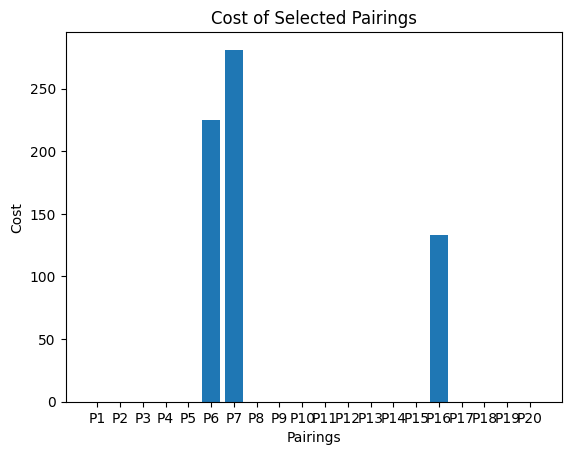

In [ ]:

# Step 9: Visualize the Solution (Optional)
try:
    import matplotlib.pyplot as plt

    # Bar chart showing the cost of selected pairings
    plt.bar(pairings.keys(), [x[p].value() * pairings[p]['cost'] for p in pairings])
    plt.xlabel("Pairings")
    plt.ylabel("Cost")
    plt.title("Cost of Selected Pairings")
    plt.show()
except ImportError:
    print("Matplotlib not installed. Skipping visualization.")